In [55]:
%%capture
%env AWS_REQUEST_PAYER=requester
%env AWS_S3_REQUESTER_PAYS=yes
%env AWS_DEFAULT_REGION=us-west-2

In [34]:
from rasterio.session import AWSSession

In [56]:
session = AWSSession.from_environ(requester_pays=True)

In [ ]:
session.credentials

---

In [2]:
from rastervision.core.box import Box
from rastervision.core.data import RasterioSource

from tqdm.auto import tqdm
import numpy as np
import torch
import geopandas as gpd
from matplotlib import pyplot as plt
import seaborn as sns
sns.reset_defaults()

---

## Load embeddings

In [4]:
# !aws s3 cp s3://raster-vision-ahassan/naip/skyscript_naip_MA_400_400.pt .
# !aws s3 cp s3://raster-vision-ahassan/naip/skyscript_naip_MA_800_800.pt .
# !aws s3 cp s3://raster-vision-ahassan/naip/skyscript_naip_MA_1600_1600.pt .

In [3]:
embs_400 = torch.load('data/skyscript_naip_MA_400_400.pt')
# embs_800 = torch.load('skyscript_naip_MA_800_800.pt')
# embs_1600 = torch.load('skyscript_naip_MA_1600_1600.pt')
embs_400.shape,  #embs_800.shape, #embs_1600.shape

(torch.Size([563379, 768]),)

---

## Load chip windows

In [ ]:
# !aws s3 cp s3://raster-vision-ahassan/naip/naip_MA_400_400_w_uris.json .
# !aws s3 cp s3://raster-vision-ahassan/naip/naip_MA_800_800_w_uris.json .
# !aws s3 cp s3://raster-vision-ahassan/naip/naip_MA_1600_1600_w_uris.json .

In [4]:
windows_df_400 = gpd.read_file('data/naip_MA_400_400_w_uris.json')
# windows_df_800 = gpd.read_file('naip_MA_800_800_w_uris.json')
# windows_df_1600 = gpd.read_file('naip_MA_1600_1600_w_uris.json')

---

## Init `RasterSource`s

In [61]:
uris = set(windows_df_400.uri)
_uri_to_rs = {}

---

## Load model

In [10]:
import open_clip

model_name = 'ViT-L-14'
model, _, preprocess = open_clip.create_model_and_transforms(model_name)
tokenizer = open_clip.get_tokenizer(model_name)

print('#params: ', f'{sum(p.numel() for p in model.parameters()):,}')

#params:  427,616,513


In [11]:
ckpt_path = 'data/SkyCLIP_ViT_L14_top50pct/epoch_20.pt'
ckpt = torch.load(ckpt_path, map_location='cpu')['state_dict']
ckpt = {k[len('module.'):]: v for k, v in ckpt.items()}
message = model.load_state_dict(ckpt)
model = model.eval()

## Search

In [59]:
def uri_to_rs(uri: str):
    if uri not in _uri_to_rs:
        with rio.Env(session):
            _uri_to_rs[uri] = RasterioSource(
                uri, channel_order=[0, 1, 2], allow_streaming=True)
    return _uri_to_rs[uri]

In [63]:
def emb_idx_to_chip(i, windows_df, out_shape=(400, 400)):
    i = int(i)
    uri = windows_df.uri.iloc[i]
    window_geom = windows_df.geometry.iloc[i]
    window = Box.from_shapely(window_geom)
    rs = uri_to_rs(uri)
    with rio.Env(session):
        chip = rs.get_chip_by_map_window(window, out_shape=out_shape)
    return chip

In [13]:
def show_top_chips(chip_scores,
                   windows_df,
                   top_inds=None,
                   nrows=5,
                   ncols=5,
                   figsize=(12, 12),
                   w_pad=-2.5,
                   h_pad=-2.5):
    plt.close('all')
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize)
    fig.tight_layout(w_pad=w_pad, h_pad=h_pad)
    if top_inds is None:
        top_inds = torch.topk(chip_scores, axs.size).indices
    for ax, i in zip(tqdm(axs.flat), top_inds):
        chip = emb_idx_to_chip(i, windows_df)
        ax.imshow(chip)
    for ax in axs.flat:
        ax.axis('off')
    plt.show()
    return fig

In [14]:
def get_chip_scores(text_queries, embs):
    assert len(text_queries) == 1
    text_emb = get_text_emb(text_queries)
    chip_scores = _get_chip_scores(text_emb, embs)
    return chip_scores


def get_chip_scores_pca(text_queries, embs, pca, num_pcs):
    assert len(text_queries) == 1
    text_emb = get_text_emb(text_queries)
    text_emb_pca = pca.transform(text_emb)[:, num_pcs]
    chip_scores = _get_chip_scores(text_emb, embs)
    return chip_scores


def get_text_emb(text_queries):
    with torch.inference_mode():
        text = tokenizer(text_queries)
        text_emb = model.encode_text(text)
        text_emb /= text_emb.norm(dim=-1, keepdim=True)
        text_emb = text_emb.cpu()
    return text_emb


def _get_chip_scores(text_emb, image_embs):
    with torch.inference_mode():
        chip_scores = torch.cosine_similarity(text_emb, image_embs)
    return chip_scores

In [137]:
q1 = 'dense forest'
q2 = 'water'

  0%|          | 0/8 [00:00<?, ?it/s]

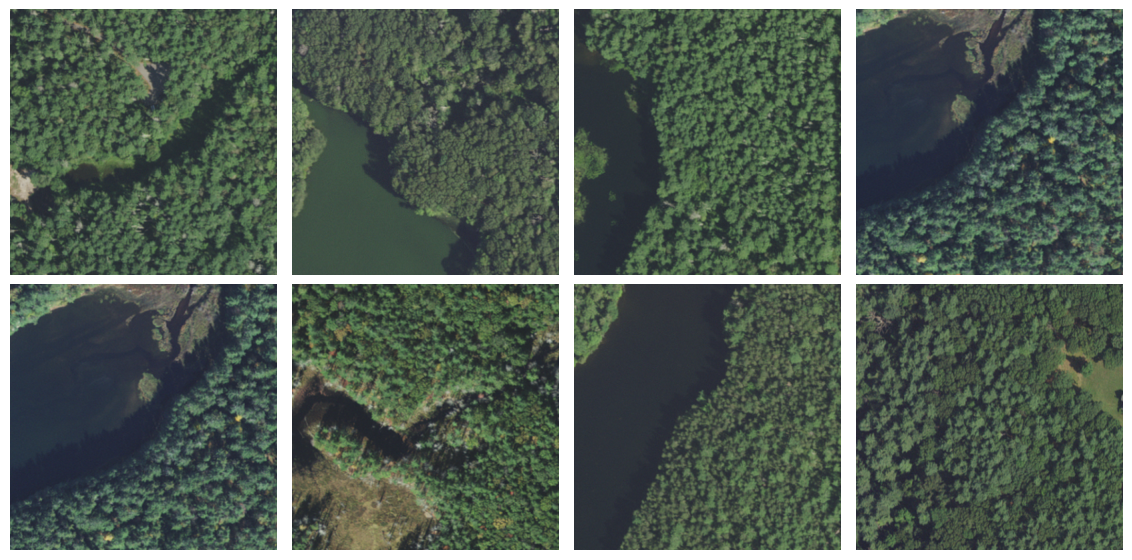

In [138]:
chip_scores_400 = get_chip_scores([q1 + ' and ' + q2], embs_400)
_ = show_top_chips(
    chip_scores_400,
    windows_df_400,
    nrows=2,
    ncols=4,
    figsize=(12, 6),
    w_pad=-(12 / 4),
    h_pad=-(6 / 4))

---

In [74]:
embs = embs_400

In [121]:
# emb1 = embs[107872]
# emb2 = embs[7035]

In [ ]:
q1 = 'dense forest'
q2 = 'large parking lot'

In [68]:
text_emb1 = get_text_emb(['dense forest'])
text_emb2 = get_text_emb(['large parking lot'])
text_emb = (1 - alpha) * text_emb1 + alpha * text_emb2
chip_scores = _get_chip_scores(text_emb, img_embs)

In [133]:
chips_all = []
with tqdm(np.linspace(0, 1, 6)) as alphas:
    for alpha in alphas:
        text_emb = (1 - alpha) * text_emb1 + alpha * text_emb2
        text_emb /= text_emb.norm(dim=-1, keepdim=True)
        chip_scores = _get_chip_scores(text_emb, img_embs)
        top_inds = torch.topk(chip_scores, 1).indices
        chips = [emb_idx_to_chip(i, windows_df_400) for i in top_inds]
        chips_all.append(chips)

  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
plt.close('all')
nrows = len(chips_all)
ncols = len(chips_all[0])
fig, axs = plt.subplots(
    nrows,
    ncols,
    figsize=(ncols * 3, nrows * 3),
    squeeze=False,
    sharex=True,
    sharey=True)
fig.tight_layout(w_pad=-2, h_pad=-2)
for ax_row, chip_row in zip(axs, chips_all):
    for ax, chip in zip(ax_row, chip_row):
        ax.imshow(chip)
for ax in axs.flat:
    ax.axis('off')
plt.show()

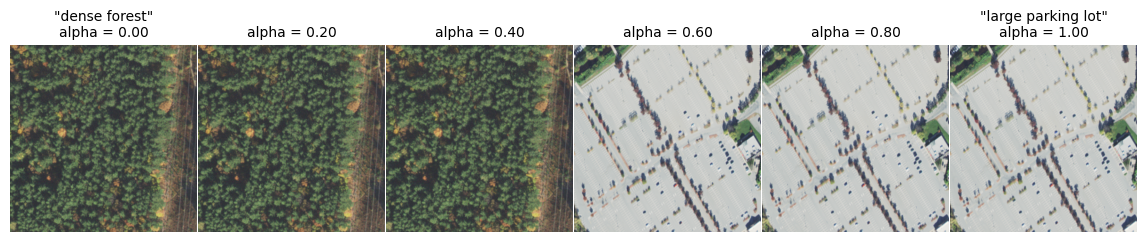

In [125]:
plt.close('all')
alphas = np.linspace(0, 1, 6)
fig, axs = plt.subplots(
    1,
    len(chips_all),
    figsize=(ncols * 3, 3),
    squeeze=True,
    sharex=True,
    sharey=True)
fig.tight_layout(w_pad=-1.5, h_pad=-2)
for ax, chip_row, alpha in zip(axs, chips_all, alphas):
    ax.imshow(chip_row[0])
    if alpha == 0:
        ax.set_title(f'"{q1}"\nalpha = {alpha:.2f}', fontsize=10)
    elif alpha == 1:
        ax.set_title(f'"{q2}"\nalpha = {alpha:.2f}', fontsize=10)
    else:
        ax.set_title(f'alpha = {alpha:.2f}', fontsize=10)
    ax.axis('off')
plt.show()

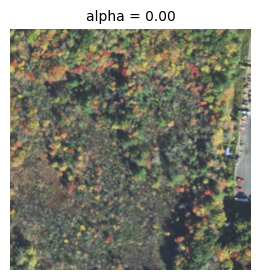

In [132]:
plt.close('all')
alphas = np.linspace(0, 1, 6)
fig, axs = plt.subplots(
    1,
    len(chips_all),
    figsize=(ncols * 3, 3),
    squeeze=False,
    sharex=True,
    sharey=True)
fig.tight_layout(w_pad=-1.5, h_pad=-2)
for ax, chip_row, alpha in zip(axs.flat, chips_all, alphas):
    ax.imshow(chip_row[0])
    ax.set_title(f'alpha = {alpha:.2f}', fontsize=10)
    ax.axis('off')
plt.show()

---

In [ ]:
!wget "https://github.com/PublicaMundi/MappingAPI/blob/master/data/geojson/us-states.json"

In [15]:
us_df = gpd.read_file('us-states.json')
aoi_df = us_df[us_df.name == 'Massachusetts']

In [155]:
top_inds = torch.topk(chip_scores_400, 100).indices
matched_windows_df = windows_df_400.iloc[top_inds]

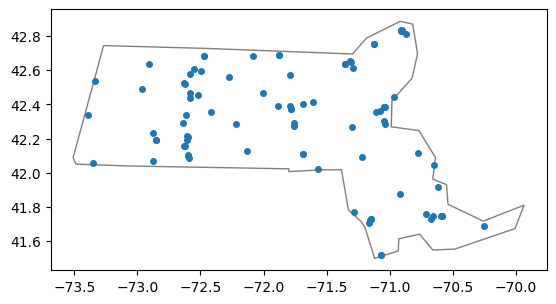

In [156]:
fig, ax = plt.subplots()
aoi_df.plot(ax=ax, ec='gray', fc='none')
intersection_df = matched_windows_df[matched_windows_df.within(
    aoi_df.unary_union)]
ax.scatter(intersection_df.centroid.x, intersection_df.centroid.y, s=16)
plt.show()

---

In [ ]:
boston_df = gpd.read_file('City_of_Boston_Boundary_(Water_Excluded).geojson')

In [83]:
boston_windows_df_400 = windows_df_400[windows_df_400.within(
    boston_df.unary_union)]
boston_inds_400 = boston_windows_df_400.emb_idx.to_numpy()
windows_df_boston_400 = windows_df_400.iloc[boston_inds]

In [148]:
chip_scores_boston_400 = chip_scores_400[boston_inds_400]
top_inds = torch.topk(chip_scores_boston_400, 100).indices
matched_windows_df = windows_df_boston_400.iloc[top_inds]

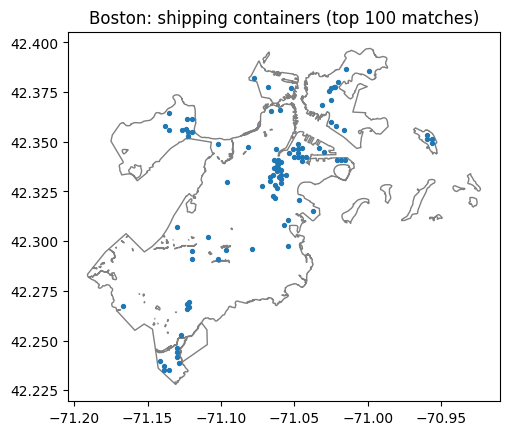

In [149]:
fig, ax = plt.subplots()
boston_df.plot(ax=ax, ec='gray', fc='none')
# boston_df.plot(ax=ax)
intersection_df = matched_windows_df[matched_windows_df.within(
    boston_df.unary_union)]
ax.scatter(intersection_df.centroid.x, intersection_df.centroid.y, s=8)
# ax.set_title('Boston: shipping facilities (top 100 matches)')
ax.set_title(f'Boston: {text_queries[0]} (top 100 matches)')
plt.show()

In [135]:
fig.savefig(
    f'boston_{text_queries[0]}_map.png',
    bbox_inches='tight',
    pad_inches=0.2,
    transparent=False)

  0%|          | 0/12 [00:00<?, ?it/s]

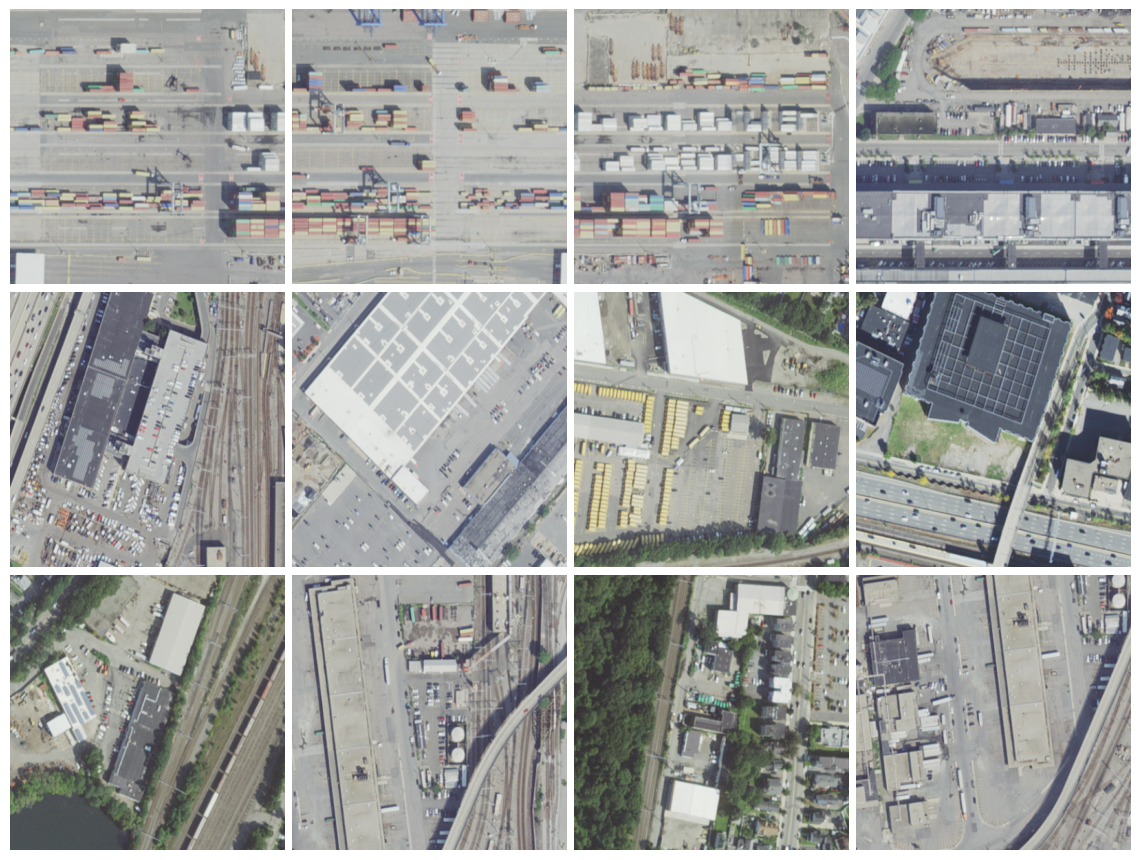

In [150]:
fig = show_top_chips(
    chip_scores_boston_400,
    windows_df_boston_400,
    nrows=3,
    ncols=4,
    figsize=(12, 9),
    w_pad=-(12 / 4),
    h_pad=-(6 / 4))

In [137]:
fig.savefig(
    f'boston_{text_queries[0]}.png',
    bbox_inches='tight',
    pad_inches=0.2,
    transparent=False)

In [102]:
def loc_to_gmaps_url(loc):
    return f'https://www.google.com/maps/@{loc.y},{loc.x},220m/data=!3m1!1e3'

In [142]:
locs = matched_windows_df.iloc[:12].centroid
print('\n'.join([loc_to_gmaps_url(loc) for loc in locs.tolist()]))

https://www.google.com/maps/@42.34018250701785,-71.04467623469122,220m/data=!3m1!1e3
https://www.google.com/maps/@42.30195301632909,-71.1085407504984,220m/data=!3m1!1e3
https://www.google.com/maps/@42.37541452922492,-71.02629627356262,220m/data=!3m1!1e3
https://www.google.com/maps/@42.341039010002476,-71.06111353229045,220m/data=!3m1!1e3
https://www.google.com/maps/@42.37762610923364,-71.02345233934405,220m/data=!3m1!1e3
https://www.google.com/maps/@42.34445070392353,-71.04772811739713,220m/data=!3m1!1e3
https://www.google.com/maps/@42.33229388593479,-71.06665377689171,220m/data=!3m1!1e3
https://www.google.com/maps/@42.38212616175248,-71.07785731592706,220m/data=!3m1!1e3
https://www.google.com/maps/@42.26745244638931,-71.1664985829871,220m/data=!3m1!1e3
https://www.google.com/maps/@42.34239450805472,-71.04183450436871,220m/data=!3m1!1e3
https://www.google.com/maps/@42.32253655321756,-71.06449212229388,220m/data=!3m1!1e3
https://www.google.com/maps/@42.2373998079851,-71.13852921465273,2

---

In [ ]:
boston_df = gpd.read_file('City_of_Boston_Boundary_(Water_Excluded).geojson')

In [44]:
boston_windows_df = windows_df_800[windows_df_800.within(
    boston_df.unary_union)]
windows_df_boston_800 = windows_df_800.iloc[boston_inds]

In [38]:
boston_inds = boston_windows_df.emb_idx.to_numpy()
chip_scores_boston_800 = chip_scores_800[boston_inds]
chip_scores_boston_800.shape

torch.Size([382])

In [45]:
top_inds = torch.topk(chip_scores_boston_800, 30).indices
matched_windows_df = windows_df_boston_800.iloc[top_inds]

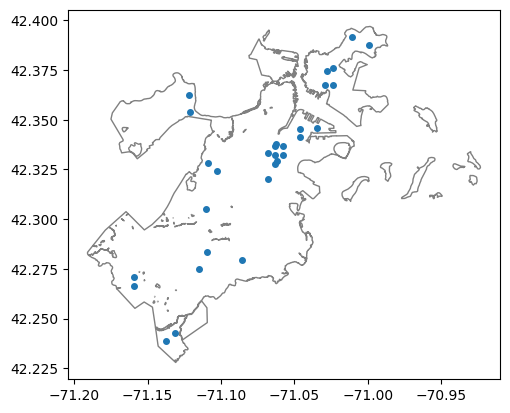

In [46]:
fig, ax = plt.subplots()
boston_df.plot(ax=ax, ec='gray', fc='none')
# boston_df.plot(ax=ax)
intersection_df = matched_windows_df[matched_windows_df.within(
    boston_df.unary_union)]
ax.scatter(intersection_df.centroid.x, intersection_df.centroid.y, s=16)
plt.show()

  0%|          | 0/8 [00:00<?, ?it/s]

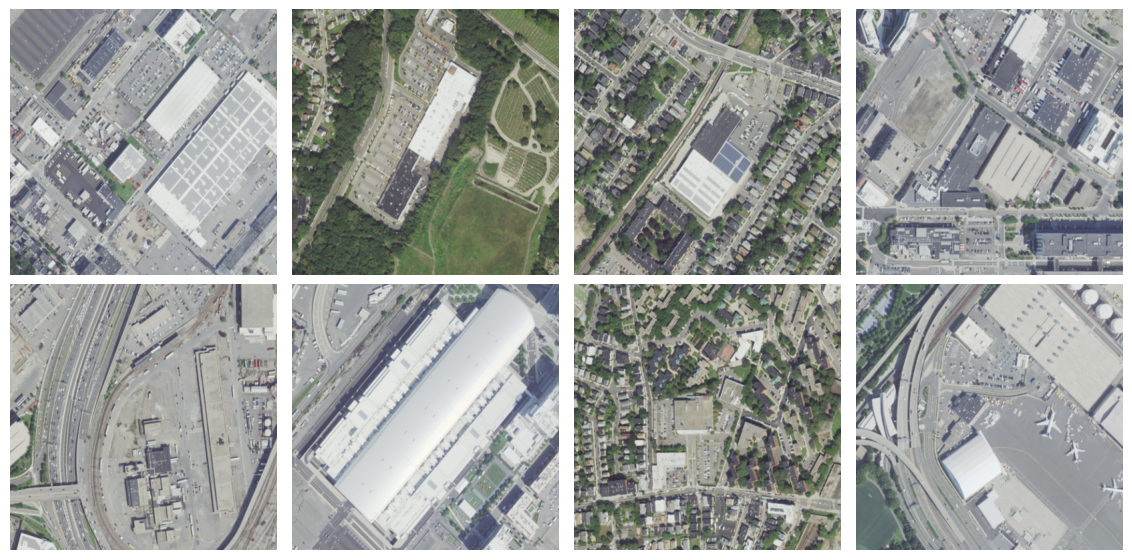

In [77]:
show_top_chips(
    chip_scores_boston_800,
    windows_df_boston_800,
    nrows=2,
    ncols=4,
    figsize=(12, 6),
    w_pad=-(12 / 4),
    h_pad=-(6 / 4))